In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pysam

ref = "taatggaaacttcctcatgaaaaagtctttagtcctcaaagcctctgtagccgttgctaccctcgttccgatgctgtctttcgctgctgagggtgacgatcccgcaaaagcggcctttgactccctgcaagcctcagcgaccgaatatatcggttatgcgtgggcgatggttgttgtcattgtcggcgcaactatcggtatcaagctgtttaagaaattcacctcgaaagcaagttgataaactgatacaattaaaggctccttttggagcctttttttttggagtaaggaggaaaaatgtccgcgaaagcgcagaacgatccgctgctgccgggctatagctttaacgcacatctggtggcgggcctgaccccgattgaagcgaacggctatctggatttttttattgatcgcccgctgggcatgaaaggctatattctgaacctgaccattcgcggccagggcgtggtgaaaaaccagggccgcgaatttgtgtgccgcccgggcgatattctgctgtttccgccgggcgaaattcatcattatggccgccatccggaagcgcgagaatggtatcatcagtgggtgtattttcgcccgcgcgcgtattggcatgaatggctgaactggccgagcatttttgcgaacaccggcttttttcgcccggatgaagcgcatcagccgcattttagcgatctgtttggccagattattaacgcgggccagggcgaaggcctctatagcgaactgctgacaattaacctgctggaacagctgctgctgcgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcgcgaagcgtgccagtatattagcgatcatctggcggatagcaactttgatattgcgagcgtggcgcagcatgtgtgcctgagccctagccgcctgagccatctgtttcgccagcagctgggcattagcgtgctgagctggcgcgaagatcagcgcattagccaggcgaaactgctgctgagcaccacccgcatgccgattgcgaccgtgggcctcaacgtgggctttgatgatcagctgtattttagccgcgtgtttaaaaaatgcaccggcgcgagcccgagcgaatttcgcgcgggctgcgaagaaaaagtgaacgatgtggcggtgaaactgagcgggtaaggctaatggagattttcaacatgggctagcacagccctaggtattatgctagcgtggtgtctgcgtaataaggagtcttaatcatgccagttcttttgggtattccgttattattgcgtttcctcggtttccttctggtaactttgttcggctatctgcttacttttctcaaaaagggcttcggtaagatagctattgctatttcattgtttcttgctcttattattgggcttaactcaattcttgtgggttatctctctgatattagtgctcaattaccctctgactttgttcagggtgttcagttaattctcccgtctaatgcgcttccctgtttttatgttattctctctgt".upper()

In [37]:
import pysam

# Open the BAM file
samfile = pysam.AlignmentFile("/var/lib/minknow/data/basecalling/pass/barcode01/alignment/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.bam", "r")

# Prepare to store mutations by read
read_mutations = {}
excluded_reads = 0
included_reads = 0

# Iterate over reads in the SAM file
for read in samfile.fetch():
    mutations = []
    try:
        md_tag = read.get_tag("MD")  # Try to get the MD tag
        included_reads += 1
    except KeyError:
        excluded_reads += 1 
        continue  # If missing, skip this read
    print(read.start, len(read.seq))
    
    # Iterate over the aligned pairs of the read
    for pos, ref_base_index, query_base in read.get_aligned_pairs(with_seq=True):
        # Fetch the actual reference base using the index
        if ref_base_index is not None:  # Make sure there is a reference base
            #print(pos, ref_base_index, query_base)
            ref_base = ref[ref_base_index]
        
            if query_base != ref_base:  # A mismatch (SNP)
                mutations.append((pos, query_base))

    # Detect indels in CIGAR string
    #print(read.cigartuples)
    for pos,(cigop, length) in enumerate(read.cigartuples):
        if cigop == 1:  # Insertion (I)
            mutations.append((pos, f"I", read.query_sequence[pos:pos+length]))
        elif cigop == 2:  # Deletion (D)
            mutations.append(((pos, f"D", ref[pos:pos+length]))) 
    
    
    read_mutations[read.query_name] = mutations

# Print out the mutations found in each read
for read_name, mutations in read_mutations.items():
    print(f"Read: {read_name} Mutations: {mutations}")


AttributeError: 'pysam.libcalignedsegment.AlignedSegment' object has no attribute 'start'

In [3]:
bamfile = pysam.AlignmentFile("/var/lib/minknow/data/basecalling/pass/barcode01/alignment/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.bam", "r")


In [4]:
A_count, C_count, G_count, T_count = bamfile.count_coverage("AraC_S170_LOV_R2", quality_threshold=15)


In [28]:
M_cigar = []
I_cigar = []
D_cigar = []

for read in bamfile.fetch():
    cigar_stats = read.get_cigar_stats()
    if len(cigar_stats[0])>2:
        M_cigar.append(cigar_stats[0][0])
        I_cigar.append(cigar_stats[0][1])
        D_cigar.append(cigar_stats[0][2])


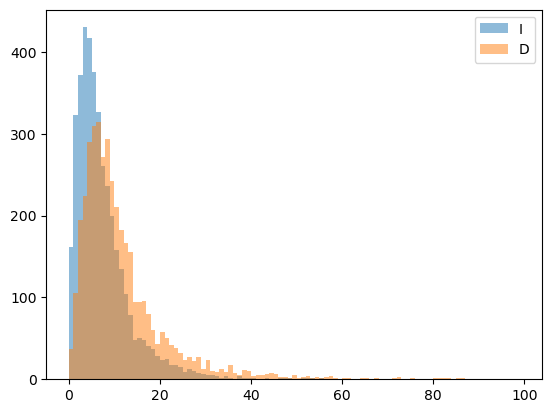

In [32]:
plt.hist(I_cigar, alpha=0.5, label='I', bins=range(0, 100))
plt.hist(D_cigar, alpha=0.5, label='D', bins=range(0, 100))
plt.legend()
plt.show()

In [14]:
y

[(array('I', [1963, 10, 9, 0, 1, 0, 0, 0, 0, 0, 26]),
  array('I', [11, 4, 6, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1969, 2, 3, 0, 1, 0, 0, 0, 0, 0, 17]),
  array('I', [5, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1969, 0, 3, 0, 1, 0, 0, 0, 0, 0, 16]),
  array('I', [2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1969, 5, 3, 0, 1, 0, 0, 0, 0, 0, 16]),
  array('I', [7, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1957, 19, 15, 0, 1, 0, 0, 0, 0, 0, 65]),
  array('I', [24, 13, 10, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1963, 1, 9, 0, 1, 0, 0, 0, 0, 0, 14]),
  array('I', [6, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1966, 6, 6, 0, 1, 0, 0, 0, 0, 0, 21]),
  array('I', [11, 4, 6, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1962, 13, 10, 0, 1, 0, 0, 0, 0, 0, 32]),
  array('I', [16, 8, 7, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1962, 6, 10, 0, 1, 0, 0, 0, 0, 0, 26]),
  array('I', [11, 4, 6, 0, 1, 0, 0, 0, 0, 0, 0])),
 (array('I', [1951, 4, 21, 0, 1, 0, 0, 0, 0, 0, 46]),
  arra

In [5]:
x = pd.DataFrame([A_count, C_count, G_count, T_count], index=["A", "C", "G", "T"])


In [7]:
import numpy as np

In [8]:
x_masked = x.copy()
for idx, ref_nt in enumerate(ref): 
    x_masked.loc[ ref_nt,idx] = np.nan


<Axes: >

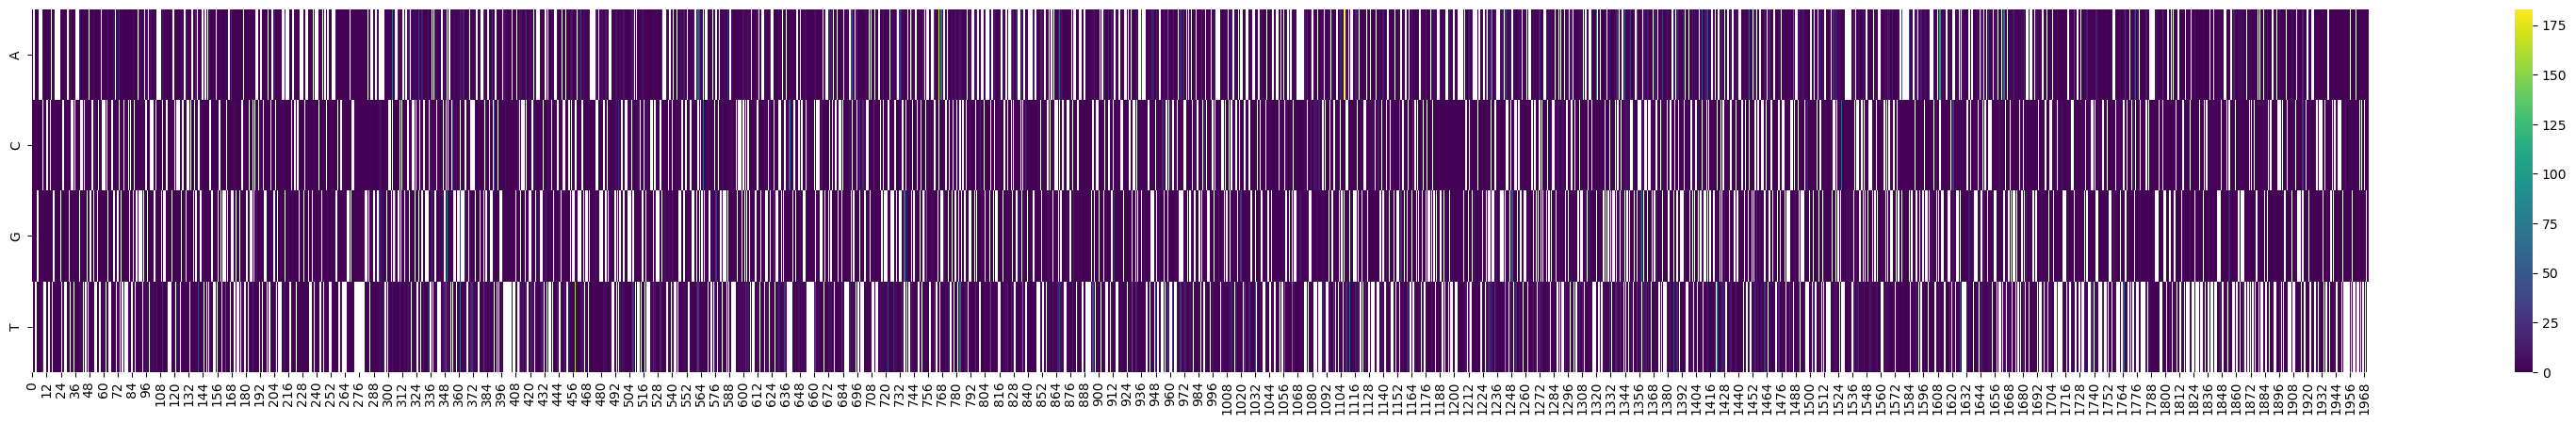

In [9]:
import seaborn as sns
plt.figure(figsize=(40, 5))
sns.heatmap(x_masked, cmap="viridis")

In [10]:
mut_rate = x_masked.sum()

In [11]:
coverage = x.sum()

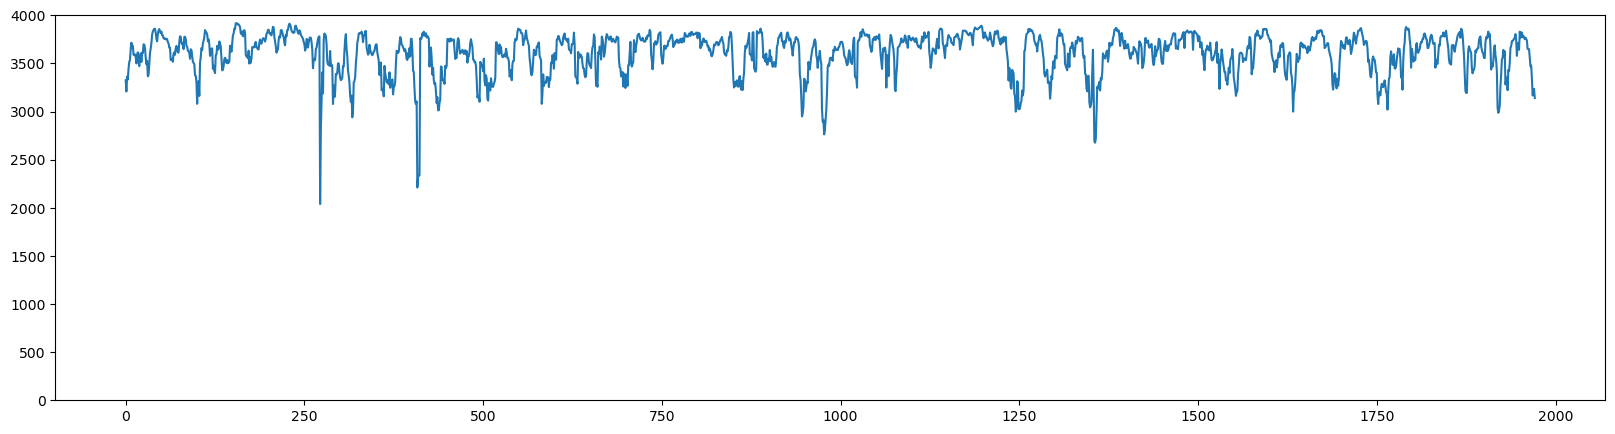

In [12]:
plt.figure(figsize=(20, 5))
plt.ylim(0, 4000)
plt.plot(coverage)

<Axes: >

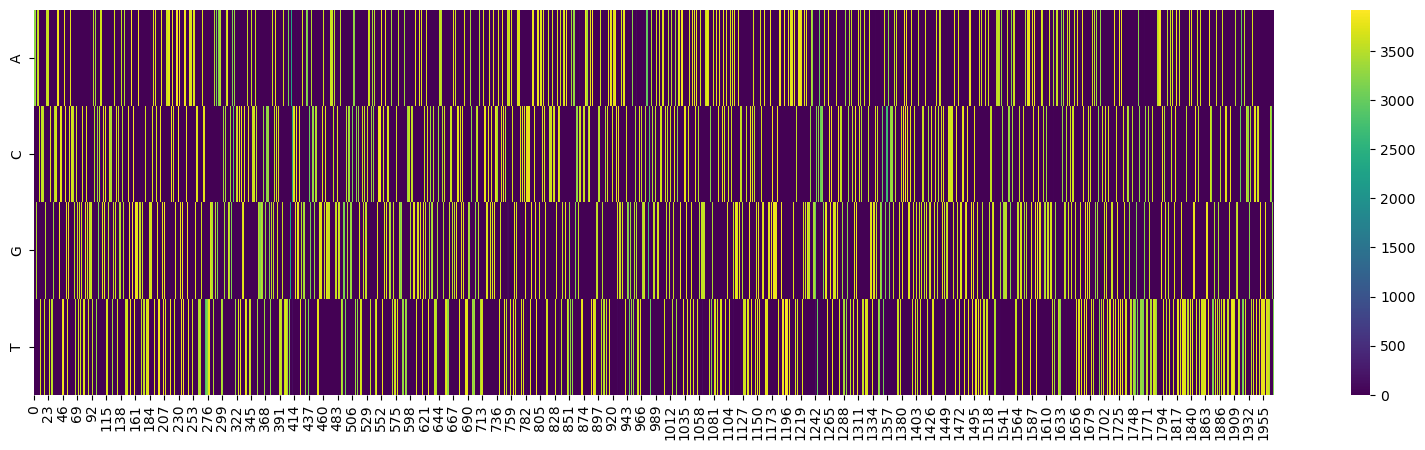

In [58]:
import seaborn as sns
plt.figure(figsize=(20, 5))
sns.heatmap(x, cmap="viridis")